In [1]:
%matplotlib inline
import torch
from torch import nn
from torch.autograd import Variable
import math
import numpy as np
from torch.nn import functional as F
import matplotlib.pyplot as plt
from deepvoice3_pytorch.modules import position_encoding_init

/Users/yusuke/anaconda3/envs/deepvoice3/lib/python3.5/site-packages/matplotlib/font_manager.py:281: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


$\mathrm{PE}_{\mathrm{pos}, 2i} = \sin(\mathrm{pos}/10000^{2i/d_{\mathrm{model}}})$

$\mathrm{PE}_{\mathrm{pos}, 2i+1} = \cos(\mathrm{pos}/10000^{2i/d_{\mathrm{model}}})$

where `pos` is the position and `i` is the dimension.

In [2]:
# position_encoding_init
''' Init the sinusoid position encoding table '''
d_pos_vec = 3
position_rate=1.0
n_position = 5

position_enc = [
    [position_rate * pos / np.power(10000, 2 * (i // 2) / d_pos_vec) for i in range(d_pos_vec)]
    if pos != 0 else np.zeros(d_pos_vec) for pos in range(n_position)]

position_enc = np.array(position_enc)
position_enc

array([[  0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  1.00000000e+00,   1.00000000e+00,   2.15443469e-03],
       [  2.00000000e+00,   2.00000000e+00,   4.30886938e-03],
       [  3.00000000e+00,   3.00000000e+00,   6.46330407e-03],
       [  4.00000000e+00,   4.00000000e+00,   8.61773876e-03]])

In [3]:
position_enc_sinusoidal = torch.from_numpy(position_enc).float()
position_enc_sinusoidal[1:, 0::2] = torch.sin(position_enc_sinusoidal[1:, 0::2]) # 2i
position_enc_sinusoidal[1:, 1::2] = torch.cos(position_enc_sinusoidal[1:, 1::2]) # 2i + 1

position_enc_sinusoidal


 0.0000  0.0000  0.0000
 0.8415  0.5403  0.0022
 0.9093 -0.4161  0.0043
 0.1411 -0.9900  0.0065
-0.7568 -0.6536  0.0086
[torch.FloatTensor of size 5x3]

In [4]:
def sinusoidal_encode(x, w):
    y = w * x
    y[1:, 0::2] = torch.sin(y[1:, 0::2].clone())
    y[1:, 1::2] = torch.cos(y[1:, 1::2].clone())
    return y

In [5]:
# class SinusoidalEncoding(nn.Embedding)

help(nn.Embedding)
    

Help on class Embedding in module torch.nn.modules.sparse:

class Embedding(torch.nn.modules.module.Module)
 |  A simple lookup table that stores embeddings of a fixed dictionary and size.
 |  
 |  This module is often used to store word embeddings and retrieve them using indices.
 |  The input to the module is a list of indices, and the output is the corresponding
 |  word embeddings.
 |  
 |  Args:
 |      num_embeddings (int): size of the dictionary of embeddings
 |      embedding_dim (int): the size of each embedding vector
 |      padding_idx (int, optional): If given, pads the output with zeros whenever it encounters the index.
 |      max_norm (float, optional): If given, will renormalize the embeddings to always have a norm lesser than this
 |      norm_type (float, optional): The p of the p-norm to compute for the max_norm option
 |      scale_grad_by_freq (boolean, optional): if given, this will scale gradients by the frequency of
 |                                           

In [6]:
class SinusoidalEncoding(nn.Embedding):
    def __init__(self, num_embeddings, embedding_dim, padding_idx=0, *args, **kwargs):
        super(SinusoidalEncoding, self).__init__(num_embeddings, embedding_dim, padding_idx, *args, **kwargs)
        self.weight.data = position_encoding_init(num_embeddings, embedding_dim, position_rate, sinusoidal=False)
    
    def forward(self, x, w=1.0):
        assert np.isscalar(w)
        weight = sinusoidal_encode(self.weight, w)
        return self._backend.Embedding.apply(
            x, weight, self.padding_idx, self.max_norm, self.norm_type, self.scale_grad_by_freq, self.sparse
        )

In [7]:
# test_sinusoidal

num_embedding = 512
embedding_dim = 128
padding_idx = 0

a = nn.Embedding(num_embedding, embedding_dim, padding_idx=padding_idx)
a.weight.data = position_encoding_init(num_embedding, embedding_dim, position_rate=1.0)

b = SinusoidalEncoding(num_embedding, embedding_dim, padding_idx=padding_idx)

x = Variable(torch.arange(0, 128).long())

w = 1.0

ax = a(x).data.numpy()
bx = b(x, w).data.numpy()

np.abs(ax - bx).mean()

0.0

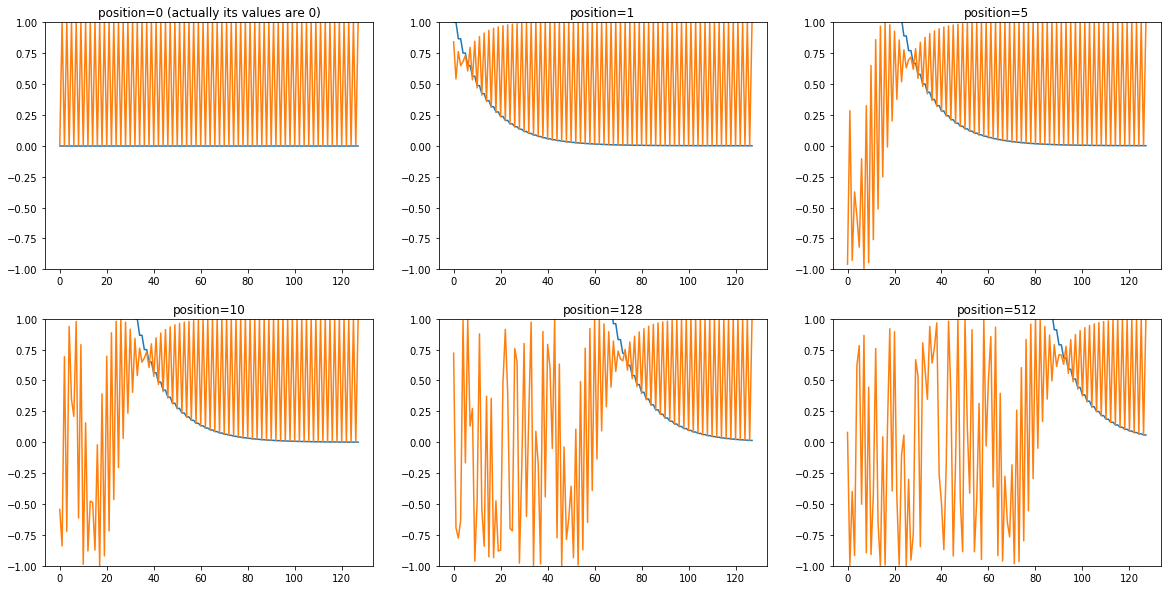

In [36]:
d_pos_vec = 128

def single_position(position_idx, d_pos_vec, position_rate=1.0):
    pos = [position_rate * position_idx / np.power(10000, 2 * (i // 2) / d_pos_vec) for i in range(d_pos_vec)]
    pos_sinusoidal = pos.copy()

    pos_sinusoidal[0::2] = np.sin(pos_sinusoidal[0::2])
    pos_sinusoidal[1::2] = np.cos(pos_sinusoidal[1::2])
    return pos, pos_sinusoidal

plt.figure(figsize=(20, 10))

for i, pos in enumerate([0, 1, 5, 10, 128, 512], 1):
    pos_exp, pos_sinusoidal = single_position(pos, d_pos_vec)
    plt.subplot(2,3, i)
    if pos == 0:
        plt.title("position={} (actually its values are 0)".format(pos))
    else:
        plt.title("position={}".format(pos))
    plt.ylim(-1, 1)
    plt.plot(pos_exp)
    plt.plot(pos_sinusoidal)


In [44]:
# conv.py

class Conv1d(nn.Conv1d):
    """Extended nn.Conv1d for incremental dilated convolutions
    currently limited for odd number kernel sizes
    """
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.clear_buffer()
        self._linearized_weight = None
        self.register_backward_hook(self._clear_linearized_weight)
    
    def incremental_forward(self, input):
        # input: (B, T, C)
        if self.training:
           raise RuntimeError('incremental_forward only supports eval mode')
    
        # run forward pre hooks (e.g., weight norm)
        for hook in self._forward_pre_hooks.values():
            hook(self, input)
        
        # reshape weight
        weight = self._get_linearlized_weight()
        kw = self.kernel_size[0]
        dilation = self.dilation[0]
        
        # input: bsz x len x dim
        # bsz stands for batch size
        bsz = input.size(0)
        if kw > 1:
            assert kw % 2 == 1
            input = input.data
            if self.input_buffer is None:
                self.input_buffer = input.new(bsz, kw + (kw - 1) * (dilation - 1), input.size(2))
                self.input_buffer.zero_()
            else:
                # shift buffer
                self.input_buffer[:, :-1, :] = self.input_buffer[:, 1:, :].clone()
            # append next input
            self.input_buffer[:, -1, :] = input[:, -1, :]
            '''torch.autograd.Variable
             |      volatile: Boolean indicating that the Variable should be used in
 |          inference mode, i.e. don't save the history. See
 |          :ref:`excluding-subgraphs` for more details.
 |          Can be changed only on leaf Variables.
 '''
            input = torch.autograd.Variable(self.input_buffer, volatile=True)
            if dilation > 1:
                raise NotImplementedError
                
        '''torch.Tensor.view 
    view(...)
    view(*args) -> Tensor
    
    Returns a new tensor with the same data but different size.
    
    The returned tensor shares the same data and must have the same number
    of elements, but may have a different size. A tensor must be
    :func:`contiguous` to be viewed.
    
    Args:
        args (torch.Size or int...): Desired size
    '''
        output = F.linear(input.view(bsz, -1), weight, self.bias)
        return output.view(bsz, 1, -1) # the size -1 is inferred from other dimensions
    
    def clear_buffer(self):
        self.input_buffer = None
    
    def _get_linearlized_weight(self):
        if self._linearized_weight is None:
            kw = self.kernel_size[0]
            # nn.Conv1d
            if self.weight.size() == (self.out_channels, self.in_channels, kw):
                weight = self.weight.transpose(dim0=1,dim1=2).contiguous()
            else:
                # fairseq.modules.conv_tbc.ConvTBC
                weight = self.weight.transpose(2, 1).transpose(1,0).contiguous()
            assert weight.size() == (self.out_channels, kw, self.in_channels)
            self._linearized_weight = weight.view(self.out_channels, -1)
        return self._linearized_weight
    
    def _clear_linearized_weight(self, *args):
        self._linearized_weight = None
    
    

In [53]:
# test_conv.py

def test_conv1d_incremental(kernel_size, dilation, T, B, C):
    kernel_size = 3
    dilation = (dilation,)
    
    # causal=True
    padding = (kernel_size - 1) * dilation[0]
    
    '''
    torch.nn.Module.eval(self)
    Sets the module in evaluation mode.
    
    This has any effect only on modules such as Dropout or BatchNorm.
    
    torch.nn.Dropout
    during evaluation the module simply computes an
 |  identity function.
    '''
    # weight: (Cout, Cin, K)
    conv = nn.Conv1d(
        C, C * 2, kernel_size=kernel_size, padding=padding,
        dilation=dilation).eval()
    conv.weight.data.fill_(1.0)
    conv.bias.data.zero_()
    
    # weight: (K, Cin, Cout)
    # weight: (linearied): (Cout*K, Cin)
    conv_online = Conv1d(
        C, C * 2, kernel_size=kernel_size, padding=padding,
        dilation=dilation).eval()
    conv_online.weight.data.fill_(1.0)
    conv_online.bias.data.zero_()
    
    # (B, C, T)
    bct = Variable(torch.zeros(B, C, T) + torch.arange(0, T))
    output_conv = conv(bct)
    
    # Remove future time steps
    output_conv = output_conv[:, :, :T]
    
    output_conv_online = []
    
    # B, T, C
    btc = bct.transpose(1,2).contiguous()
    for t in range(btc.size(1)):
        input = btc[:, t, :].contiguous().view(B, -1, C)
        output = conv_online.incremental_forward(input)
        output_conv_online += [output]
    
    '''
    torchstack(sequence, dim=0, out=None)
    Concatenates sequence of tensors along a new dimension.
    
    All tensors need to be of the same size.'''
    
    '''
    torch.squeeze(...)
    squeeze(input, dim=None, out=None)
    
    Returns a `Tensor` with all the dimensions of :attr:`input` of size `1` removed.
    
    If `input` is of shape: :math:`(A x 1 x B x C x 1 x D)` then the `out` Tensor
    will be of shape: :math:`(A x B x C x D)`
    
    When :attr:`dim` is given, a squeeze operation is done only in the given
    dimension. If `input` is of shape: :math:`(A x 1 x B)`, `squeeze(input, 0)`
    leaves the Tensor unchanged, but `squeeze(input, 1)` will squeeze the tensor
    to the shape :math:`(A x B)`'''
    output_conv_online = torch.stack(output_conv_online).squeeze(2)
    output_conv_online = output_conv_online.transpose(0, 1).transpose(1,2)
    
    assert (output_conv == output_conv_online).all()
    
#     print(output_conv)
#     print(output_conv_online)
#     print("-" * 100)

In [54]:
for B in [1,16]:
    for T in [10, 20, 30]:
        for C in [1,2,4]:
            for kernel_size in [3,5,9]:
                for dilation in [1]:
                    test_conv1d_incremental(kernel_size, dilation, T, B, C)

In [42]:
def conv1d(in_channels, out_channels, kernel_size, dropout=0, std_mul=4.0, **kwargs):
    m = Conv1d(in_channels, out_channels, kernel_size, **kwargs)
    # Gehring et al. 2017 advise to initialize weights with mean=0, std=\sqrt{4p/n} if output is activated by GLU
    # and mean=0, std=\sqrt{p/n} otherwise
    # where n is the number of inputs, and p is dropout probability
    std = math.sqrt((std_mul * (1.0 - dropout)) / (m.kernel_size[0] * in_channels))
    m.weight.data.normal(mean=0, std=std)
    m.bias.data.zero_()
    return nn.utils.weight_norm(m)

In [56]:
class NonCausalConv1dGLU(nn.Module):
    """(Dilated) Conv1d + Gated linear unit
    """
    
    def __init__(self, in_channels, out_channels, kernel_size, dropout, padding=None, dilation=1, *args, **kwargs):
        super(Conv1dGLU, self).__init__()
        self.dropout = dropout
        if padding is None:
            padding = (kernel_size - 1) // 2 * dilation
        
        self.conv = conv1d(in_channels, 2 * out_channels, kernel_size, dropout=dropout, padding=padding, dilation=dilation, *args, **kwargs)
    
    def forward(self, x):
        return self._forward(x, is_incremental=False)
    
    def _forward(self, x, is_incremental):
        residual = x
        x = F.dropout(x, p=self.dropout, training=self.training)
        if is_incremental:
            splitdim = -1
            x = self.conv.incremental_forward(x)
        else:
            splitdim = 1
            x = self.conv(x)
            # remove future time steps
            x = x[:, :, :residual.size(-1)] if self.causal else x
            
        a, b = x.split(x.size(splitdim) // 2, dim=splitdim)
        # GLU
        x = a * F.sigmoid(b)
        # to preserve variance after residual connection, scale by \sqrt{0.5}
        return (x + residual) * math.sqrt(0.5) if self.residual else x
    
    def clear_buffer(self):
        self.conv.clear_buffer()